## **Table of Contents**
* [Quantum Teleportation](#1)
* [Superdense Coding](#2)

In [26]:
# Required Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy import pi, random

<a id='1'></a>
## Quantum Teleportation

Here is a quantum circuit implementation of the teleportation protocol.

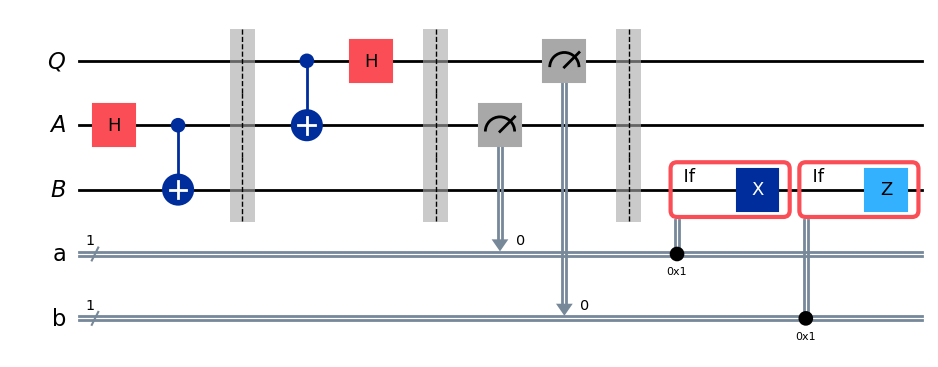

In [27]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw(output='mpl'))

 The `barrier` function creates a visual separation making the circuit diagram more readable, and it also prevents Qiskit from performing various simplifications and optimizations across barriers during compilation when circuits are run on real hardware. The `if_test` function applies an operation conditionally depending on a classical bit or register.

The circuit first initializes $(A,B)$ to be in a $∣\phi^{+}⟩$ bell state (which is not part of the protocol itself), followed by Alice's operations, then her measurements, and finally Bob's operations. Remember that by convention, Qiskit initializes all qubits in the $∣0⟩$ state when they are created.

To test that the protocol works correctly, we'll apply a randomly generated single-qubit gate to the initialized $∣0⟩$ state of $Q$ to obtain a random quantum state vector to be teleported. By applying the inverse (i.e., conjugate transpose) of that gate to $B$ after the protocol is run, we can verify that the state was teleported by measuring to see that it has returned to the $∣0⟩$ state.

First we'll randomly choose a unitary qubit gate.

In [28]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)

display(random_gate.to_matrix())

array([[ 0.99922755+0.j        , -0.01860548+0.03461412j],
       [-0.02082587+0.03332543j,  0.49566978+0.86762156j]])

Now we'll create a new testing circuit that first applies our random gate to $Q$ then runs the teleportation circuit, and finally applies the inverse of our random gate to the qubit $B$ and measures. The outcome should be 0 with certainty.

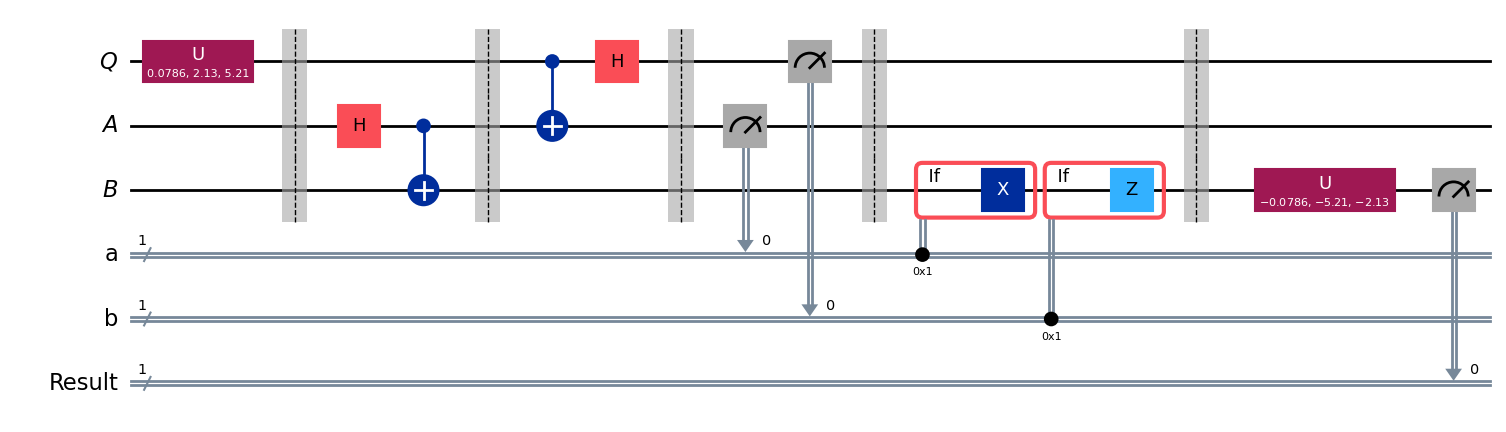

In [29]:
# Create a new circuit including the same bits and qubits used in the teleportation protocol
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q
test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above
test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure
test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw(output='mpl'))

Finally let's run the Aer simulator on this circuit and plot a histogram of the outputs. We'll see the statistics for all three classical bits: the bottom/leftmost bit should always be 0, indicating that the qubit Q was successfully teleported into B, while the other two bits should be roughly uniform.

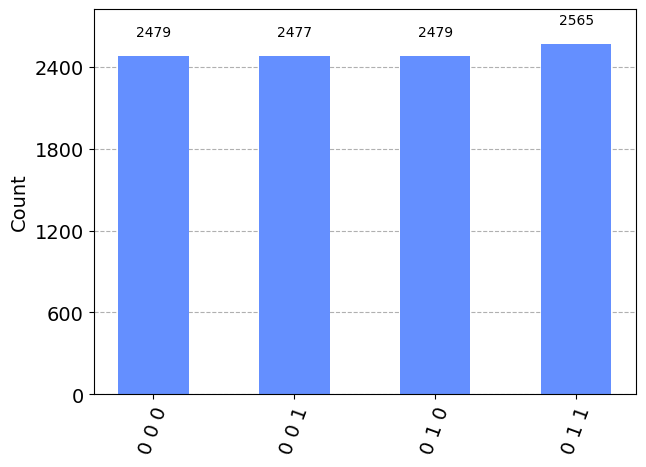

In [30]:
result = AerSimulator().run(test, shots=10000).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

We can also filter the statistics to focus just on the test result qubit if we wish, like this:

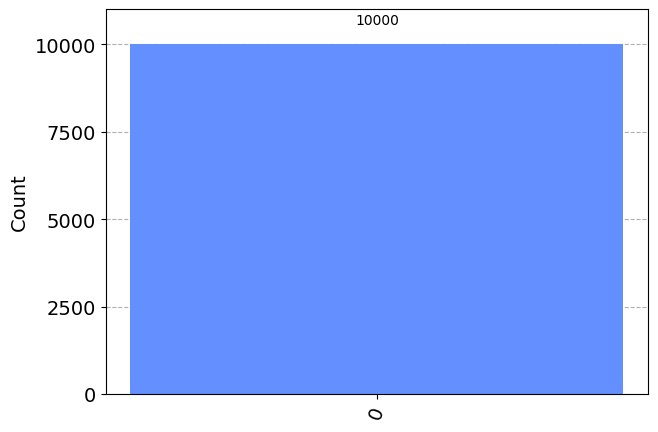

In [31]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

<a id='2'></a>
## Superdense Coding

Here is a simple implementation of superdense coding where we specify the circuit itself depending on the bits to be transmitted. First let's specify the bits to be transmitted. (Try changing the bits to see that it works correctly.)

In [32]:
c = "1"
d = "0"

Now we'll build the circuit accordingly. Here we'll just allow Qiskit to use the default names for the qubits: $q_0$ for the top qubit and $q_1$ for the bottom one.

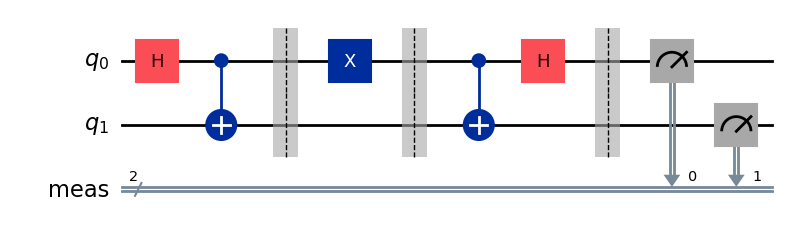

In [33]:
protocol = QuantumCircuit(2)

# Prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw(output='mpl'))

Not much is new here, except the `measure_all` function, which measures all of the qubits and puts the results into a single classical register (therefore having two bits in this case).

Running the Aer simulator produces the expected output.

Measured 10 with frequency 1.0


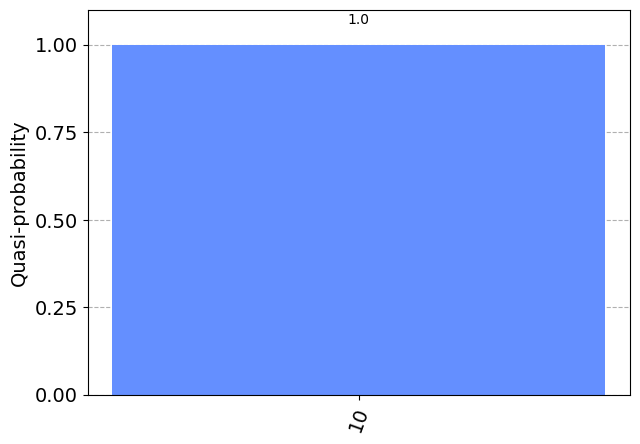

In [34]:
result = Sampler().run(protocol, shots=10000).result()
statistics = result.quasi_dists[0].binary_probabilities()

for outcome, freq in statistics.items():
    print(f"Measured {outcome} with frequency {freq}")
    
display(plot_histogram(statistics))

Just for fun, we can use an additional qubit as a random bit generator to randomly choose $c$ and $d$, then run the superdense coding protocol to see that these bits are transmitted correctly.

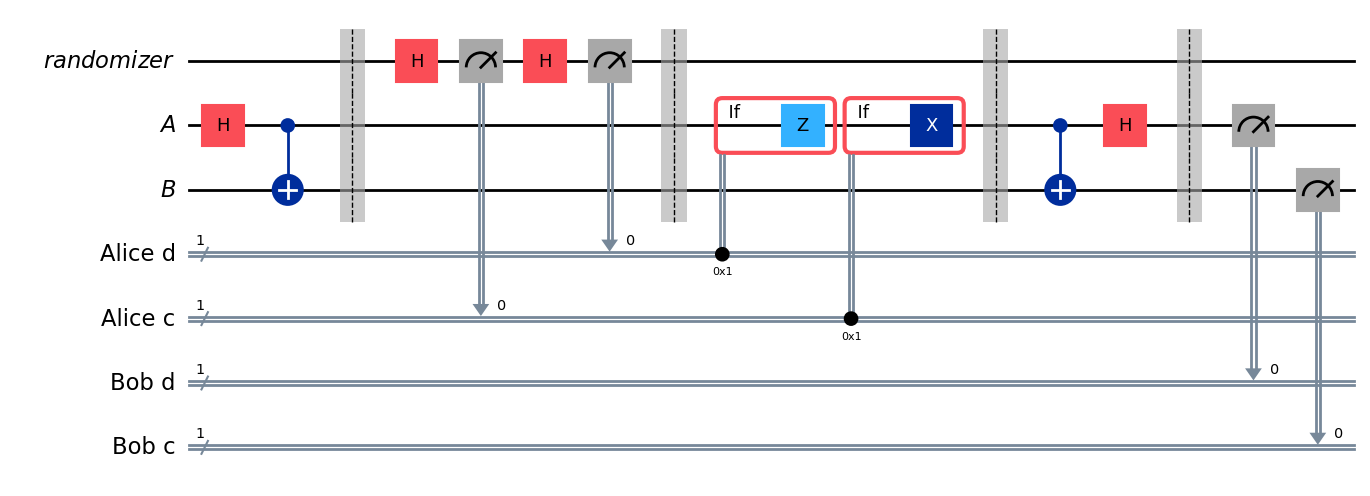

In [35]:
rbg = QuantumRegister(1, "randomizer")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'randomizer' qubit twice to generate Alice's bits c and d.
test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()

# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw(output='mpl'))


Running the Aer simulator shows the results: Alice and Bob's classical bits always agree.

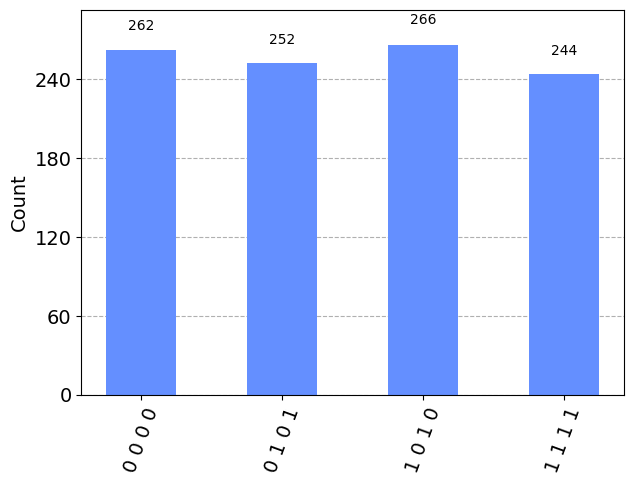

In [36]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))